In [1]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns 

from numba import njit, prange  # just-in-time compiler for parallel computation

Let's consider 2 populations that are in competition; $y_1(t),\ y_2(t)$ - sizes of these populations.

Assuming that in small time interval $\Delta t$:
*   the probability of a birth for the first population is $b_1y_1\Delta t = \frac{5}{6}y_1\Delta t$  
*   the probability of a birth for the second population is $b_2y_2\Delta t = \frac{9}{10}y_2\Delta t$  
* the probability of a death for the first population is $d_1y_1\Delta t = (\frac{2}{5} + \frac{1}{100}y_1+\frac{1}{45}y_2)y_1 \Delta t$
* the probability of a death for the second population is $d_2y_2\Delta t = (\frac{3}{4} + \frac{1}{150}y_2+\frac{1}{200}y_1)y_2 \Delta t$
* the initial population sizes are $y_1(0) = y_2(0) = 15$

The corresponding system of SDEs:
$$
\begin{cases}
dy_i = (b_i - d_i)y_idt + B_idW_i,\ i = 1, 2\\[5pt]
B_i = ((b_i + d_i)y_i + w)/c,\ i = 1, 2\\[5pt]
w = \sqrt{(b_1+d_1)(b_2+d_2)y_1y_2} \\[5pt]
c = \sqrt{(b_1+d_1)y_1 + (b_2+d_2)y_2 + 2w}
\end{cases}
$$

Below there are several functions for modelling this system with different return parameters and simulation ending condition based on what parameter is being studied. All of them are otherwise the same and use Monte Carlo simulation and Euler's method.



# 1. Extinction probabilities and extinction time distribution 

In [12]:
def Modelling(N):
    step = 1 / 10
    number_of_samples = N
    
    y1_0 = 15
    y2_0 = 15
    
    @njit
    def iteration():
        y1, y2 = y1_0, y2_0
        t = 0
        
        y1_hist = [y1_0]
        y2_hist = [y2_0]

        while y1 > 0 and y2 > 0:  # while both populations are not extinct
            # birth and death coefficients
            b1 = 5/6 
            b2 = 9/10
            d1 = 2/5 + 1/100 * y1 + 1/45 * y2
            d2 = 3/4 + 1/150 * y2 + 1/200 * y1
            
            # drift coefficients
            mu1 = (-d1 + b1) * y1
            mu2 = (-d2 + b2) * y2

            # diffusion coefficients
            a = (d1 + b1) * y1
            c = (d2 + b2) * y2
            w = np.sqrt(a * c)
            d = np.sqrt(a + c + 2 * w)

            B1 = (a + w) / d
            B2 = (c + w) / d
            
            W1 = np.random.normal(0, step)
            W2 = np.random.normal(0, step)
            
            y1 += mu1 * step + B1 * W1
            y2 += mu2 * step + B2 * W2
        
            t += step
        
        return y1, y2, t
        
    ext1 = []
    ext2 = []
    
    for i in prange(number_of_samples):
        y1, y2, t = iteration()
        if y1 <= 0:
            ext1.append(t)
        else:
            ext2.append(t)

    return ext1, ext2

In [13]:
np.random.seed(0)
nsamp = 100000
ext1, ext2 = Modelling(nsamp)

In [16]:
p2ext = len(ext2) / nsamp
p1ext = 1 - p2ext
print('Probability of extinction for the first population:', round(p1ext, 5))
print('Probability of extinction for the second population:', round(p2ext, 5))

Probability of extinction for the first population: 0.32144
Probability of extinction for the second population: 0.67856


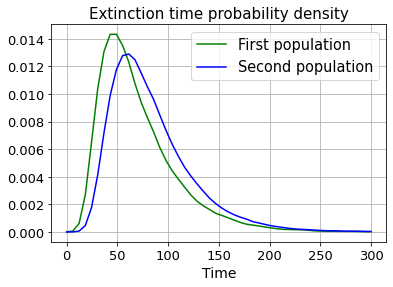

In [21]:
from scipy.stats import gaussian_kde
plt.rc('axes', titlesize=15)    # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('legend', fontsize=14.5) # legend fontsize
plt.rc('font', size=13)         # fontsize of the tick labels

t = np.linspace(0, 300)
kd1 = gaussian_kde(ext1)
kd2 = gaussian_kde(ext2)

plt.plot(t, kd1(t), 'g', label='First population')
plt.plot(t, kd2(t), 'b', label='Second population')

plt.grid()
plt.title('Extinction time probability density');
plt.xlabel('Time')
plt.legend();

# Average and median of the trajectories

Simulating the trajectories:

In [22]:
def Modelling(N, T=200):
    step = 1 / 10
    number_of_samples = N
    
    y1_0 = 15
    y2_0 = 15
    
    @njit
    def iteration():
        y1, y2 = y1_0, y2_0
        t = 0
        
        y1_hist = [y1_0]
        y2_hist = [y2_0]

        y1_dead = False
        y2_dead = False
        
        while t < T:  # modelling over a fixed time interval
        
            # birth and death coefficients
            b1 = 5/6 
            b2 = 9/10
            d1 = 2/5 + 1/100 * y1 + 1/45 * y2
            d2 = 3/4 + 1/150 * y2 + 1/200 * y1
            
            # drift coefficients
            mu1 = (-d1 + b1) * y1
            mu2 = (-d2 + b2) * y2

            # diffusion coefficients
            a = (d1 + b1) * y1
            c = (d2 + b2) * y2
            w = np.sqrt(a * c)
            d = np.sqrt(a + c + 2 * w)

            B1 = (a + w) / d
            B2 = (c + w) / d
            
            W1 = np.random.normal(0, step)
            W2 = np.random.normal(0, step)

            y1 = y1 + mu1 * step + B1 * W1 if not y1_dead else 0
            y2 = y2 + mu2 * step + B2 * W2 if not y2_dead else 0

            if y1 < 0:
                y1_dead = True
                y1 = 0
            if y2 < 0:
                y2_dead = True
                y2 = 0
        
            t += step

            y1_hist.append(y1)
            y2_hist.append(y2)
            
        return y1_hist, y2_hist
    p1 = []
    p2 = []
    for i in range(number_of_samples):
        y1, y2 = iteration()
        p1.append(y1)
        p2.append(y2)
    return np.array(p1), np.array(p2)

np.random.seed(0)
T = 200
pp1, pp2 = Modelling(10000, T=T)

Solving the determenistic system:

In [25]:
def system(y, t):
    y1, y2 = y
    b1 = 5/6
    b2 = 9/10
    d1 = 2/5 + 1/100 * y1 + 1/45 * y2
    d2 = 3/4 + 1/150 * y2 + 1/200 * y1
    dydt = [(b1 - d1) * y1, (b2 - d2) * y2]
    return dydt

y0 = [15, 15]
t = np.linspace(0, 200, 2002)

from scipy.integrate import odeint
sol = odeint(system, y0, t)

Plotting the trajectories:

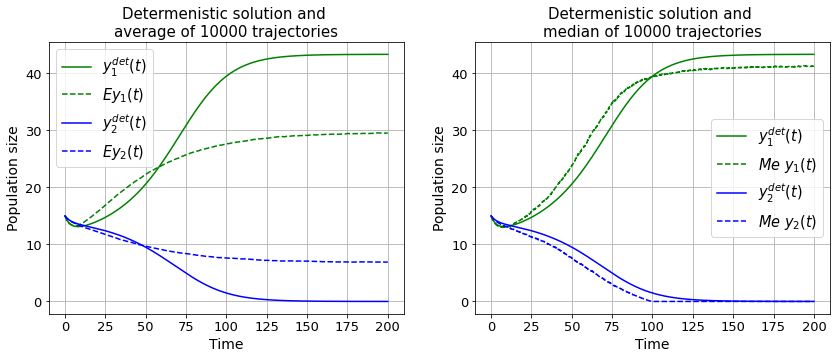

In [33]:
from scipy.stats import gaussian_kde  # used for density approximation
fig, ax = plt.subplots(1, 2, figsize=(14,5))

plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('legend', fontsize=14.5)    # legend fontsize
plt.rc('font', size=13)      # fontsize of the tick labels

ax[0].plot(t, sol[:, 0], 'g', label='$y_1^{det}(t)$')
ax[0].plot(t, np.mean(pp1, axis=0), color='green', linestyle='--', label='$Ey_1(t)$')
ax[0].plot(t, sol[:, 1], 'b', label='$y_2^{det}(t)$')
ax[0].plot(t, np.mean(pp2, axis=0), color='blue', linestyle='--', label='$Ey_2(t)$')
ax[0].legend(loc='best')


ax[0].set_title('Determenistic solution and \naverage of 10000 trajectories')

ax[0].set_xlabel('Time')
ax[0].set_ylabel('Population size')
ax[0].grid()

kd1 = gaussian_kde(ext1)
kd2 = gaussian_kde(ext2)

ax[1].plot(t, sol[:, 0], 'g', label='$y_1^{det}(t)$')
ax[1].plot(t, np.median(pp1, axis=0), color='green', linestyle='--', label='$Me\ y_1(t)$')
ax[1].plot(t, sol[:, 1], 'b', label='$y_2^{det}(t)$')
ax[1].plot(t, np.median(pp2, axis=0), color='blue', linestyle='--', label='$Me\ y_2(t)$')

ax[1].grid()

ax[1].set_title('Determenistic solution and \nmedian of 10000 trajectories');
ax[1].set_xlabel('Time');
ax[1].set_ylabel('Population size')

plt.legend();

# Estimation of the population size probabilty density at time t

In [39]:
def Modelling(N, population=1, T=200):
    step = 1 / 10
    number_of_samples = N
    
    y1_0 = 15
    y2_0 = 15
    
    @njit
    def iteration():
        y1, y2 = y1_0, y2_0
        t = 0
        
        y1_hist = [y1_0]
        y2_hist = [y2_0]

        y1_dead = False
        y2_dead = False
        
        while t < T:
            # birth and death coefficients
            b1 = 5/6 
            b2 = 9/10
            d1 = 2/5 + 1/100 * y1 + 1/45 * y2
            d2 = 3/4 + 1/150 * y2 + 1/200 * y1
            
            # drift coefficients
            mu1 = (-d1 + b1) * y1
            mu2 = (-d2 + b2) * y2

            # diffusion coefficients
            a = (d1 + b1) * y1
            c = (d2 + b2) * y2
            w = np.sqrt(a * c)
            d = np.sqrt(a + c + 2 * w)

            B1 = (a + w) / d
            B2 = (c + w) / d
            
            W1 = np.random.normal(0, step)
            W2 = np.random.normal(0, step)

            y1 = y1 + mu1 * step + B1 * W1 # if not y1_dead else 0
            y2 = y2 + mu2 * step + B2 * W2 # if not y2_dead else 0

            if y1 < 0:
                y1_dead = True
                y1 = 0
            if y2 < 0:
                y2_dead = True
                y2 = 0
        
            t += step

            y1_hist.append(y1)
            y2_hist.append(y2)
            
        return y1_hist, y2_hist
    p1 = []
    p2 = []
    i = 0
    
    for i in range(number_of_samples):
        y1, y2 = iteration()
        p1.append(y1)
        p2.append(y2)
    return np.array(p1), np.array(p2)

np.random.seed(0)
T = 200
nsamp = 3000
pp1, pp2 = Modelling(nsamp, T=T)

Filtering by which population went extinct:

In [40]:
pp1not_dead = []
for traj in pp1:
    if traj[-1] != 0:
        pp1not_dead.append(traj)
pp1not_dead = np.array(pp1not_dead)

pp2not_dead = []
for traj in pp2:
    if traj[-1] != 0:
        pp2not_dead.append(traj)
pp2not_dead = np.array(pp2not_dead)

Approximating density:

In [41]:
from scipy.stats import gaussian_kde

starting_row = 15
t = np.linspace(0, T, len(pp2not_dead[0]))[starting_row:]
X = np.linspace(0, 50, 1000)
dens1 = []
dens2 = []
tmp1 = pp1not_dead.transpose()
tmp2 = pp2not_dead.transpose()
for i in range(starting_row, len(tmp1)):
    dens1.append(gaussian_kde(tmp1[i])(X))
    dens2.append(gaussian_kde(tmp2[i])(X))
dens1 = np.array(dens1)
dens2 = np.array(dens2)
X, t = np.meshgrid(X, t)

Plotting approximated density:

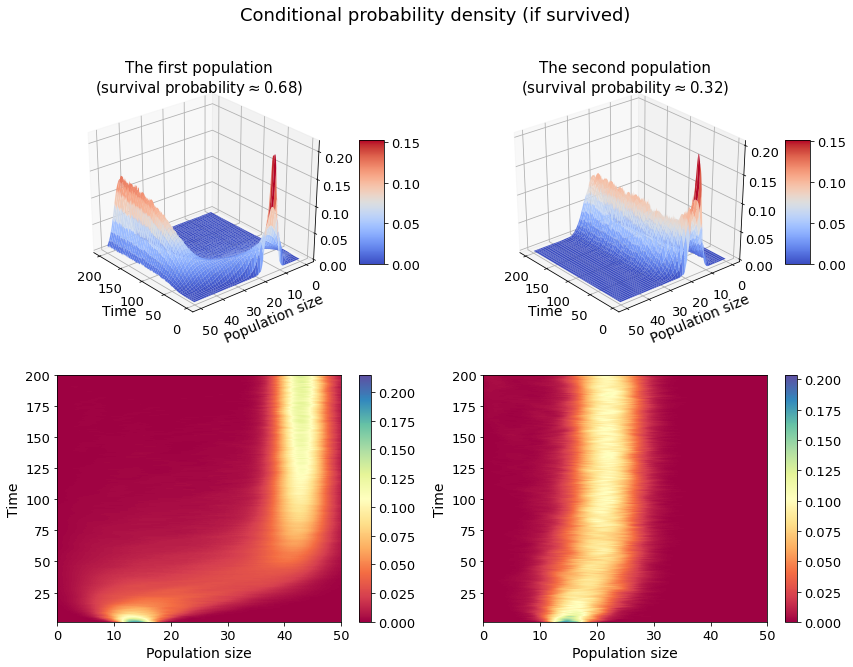

In [44]:
fig = plt.figure(figsize=(14, 10))

plt.rc('figure', titlesize=18)  # fontsize of the figure title
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)      # fontsize of the tick labels

ax = fig.add_subplot(2, 2, 1, projection='3d')
ax.set_title('The first population\n(survival probability$\\approx$0.68)')

surf = ax.plot_surface(t, X, dens1, linewidth=0, cmap=plt.get_cmap('coolwarm'))
fig.colorbar(surf, shrink=0.5, aspect=5);

ax2 = fig.add_subplot(2, 2, 2, projection='3d')
ax2.set_title('The second population\n(survival probability$\\approx$0.32)')

surf2 = ax2.plot_surface(t, X, dens2, linewidth=0, cmap=plt.get_cmap('coolwarm'))
fig.colorbar(surf2, shrink=0.5, aspect=5);

fig.suptitle('Conditional probability density (if survived)')

for a in (ax, ax2):
    a.set_xlabel('Time')
    a.set_ylabel('Population size')
    a.set_zlabel('')
    a.view_init(30, 140)

ax3 = fig.add_subplot(2, 2, 3)
im = ax3.pcolormesh(X, t, dens1, cmap=plt.get_cmap('Spectral'))
fig.colorbar(im, ax=ax3)

ax4 = fig.add_subplot(2, 2, 4)
im = ax4.pcolormesh(X, t, dens2, cmap=plt.get_cmap('Spectral'))
fig.colorbar(im, ax=ax4);

for a in ax3, ax4:
    a.set_xlabel('Population size')
    a.set_ylabel('Time')